# 🏡 Kaggle: House Prices — Advanced Regression Techniques

## Цель соревнования
Предсказать цену продажи дома на основе набора характеристик недвижимости. Это задача **регрессии** с метрикой **RMSE** (среднеквадратичная ошибка).

## Импорт библиотек

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, make_scorer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings

warnings.filterwarnings("ignore")

### Обоснование выбора моделей:

- **Ridge/Lasso** — линейные модели с регуляризацией, хорошо подходят при наличии большого количества признаков.

- **Gradient Boosting, XGBoost, LGBM, CatBoost** — ансамблевые методы, устойчивые к выбросам и отлично справляющиеся с табличными данными.

## Загрузка и объединение данных

In [12]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

full = pd.concat([train.drop("SalePrice", axis=1), test], axis=0)
y = np.log1p(train["SalePrice"])

> Мы логарифмируем `SalePrice`, чтобы сделать распределение ближе к нормальному — это повышает устойчивость моделей.

## Разведочный анализ (EDA)

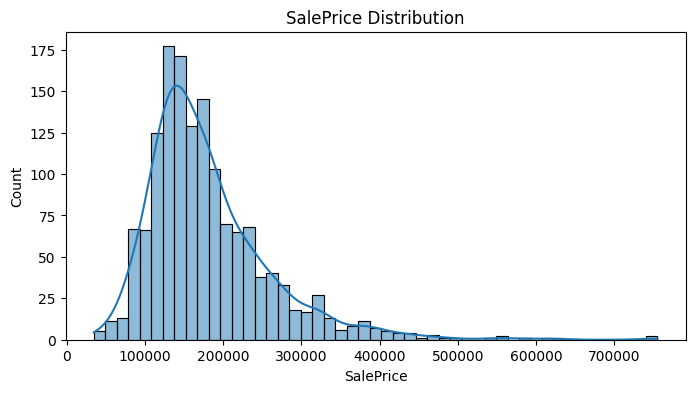

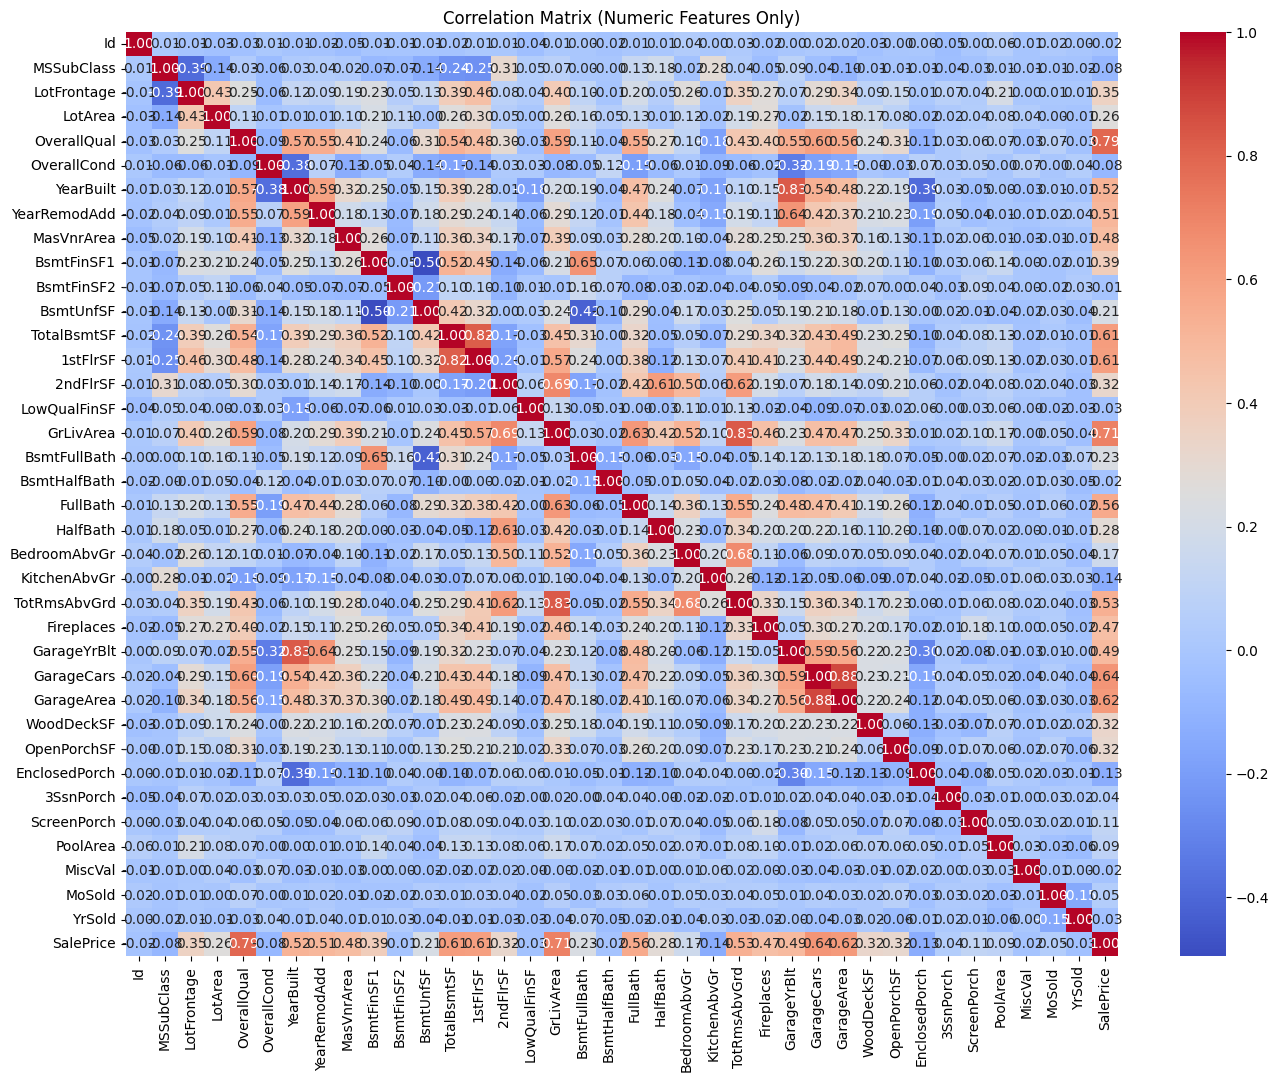

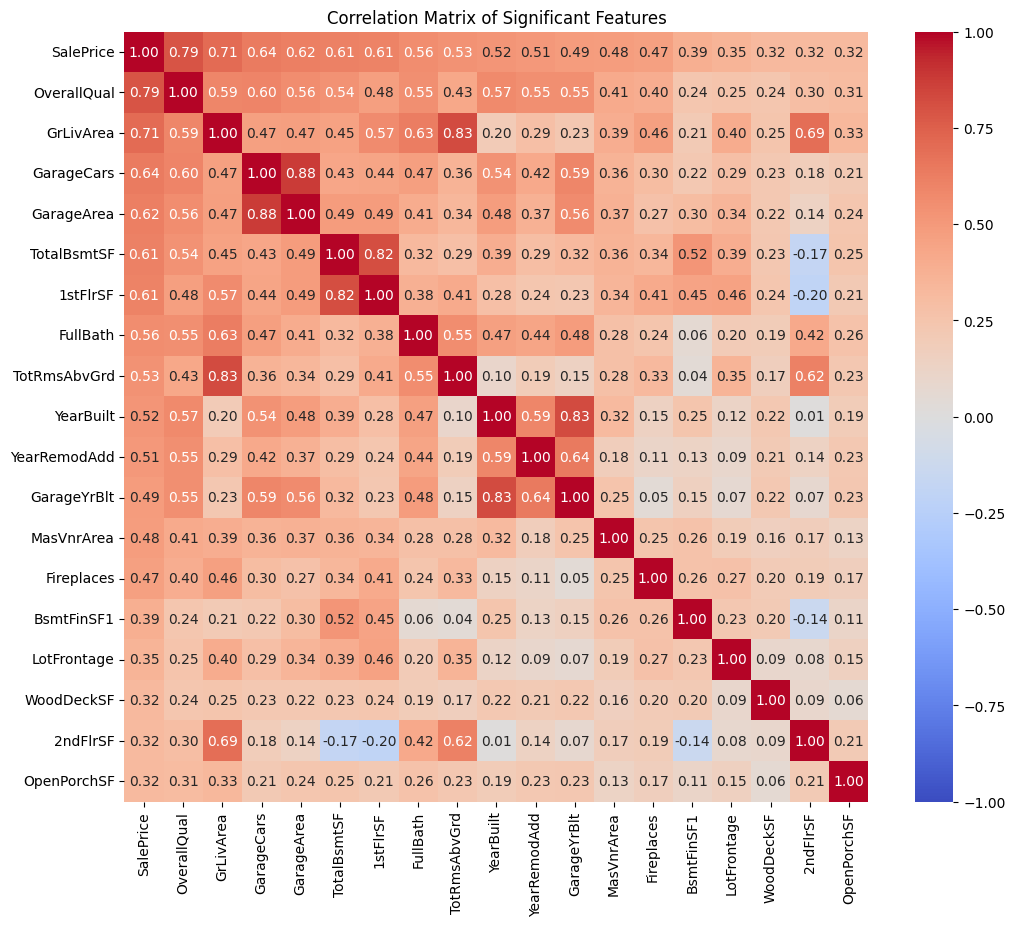

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(train['SalePrice'], kde=True)
plt.title("SalePrice Distribution")
plt.show()

numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train[numeric_cols].corr()

# Визуализация
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix (Numeric Features Only)')
plt.show()

# Выбираем только числовые столбцы
numeric_data = train.select_dtypes(include=['int64', 'float64'])

# Рассчитываем корреляцию с целевой переменной
corr_with_target = numeric_data.corrwith(numeric_data['SalePrice']).sort_values(ascending=False)

# Отбираем наиболее коррелирующие признаки (например, |correlation| > 0.3)
significant_features = corr_with_target[abs(corr_with_target) > 0.3].index

# Строим матрицу только для значимых признаков
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_data[significant_features].corr(), 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f",
            vmin=-1, vmax=1)
plt.title('Correlation Matrix of Significant Features')
plt.show()

> Анализ распределения целевой переменной выявляет скошенность. Логарифм помогает устранить её.

## Обработка пропусков

In [14]:
cat_cols = full.select_dtypes(include='object').columns
num_cols = full.select_dtypes(include=['int64', 'float64']).columns

for col in cat_cols:
    full[col] = full[col].fillna("None")
  
for col in num_cols:
    full[col] = full[col].fillna(full[col].median())

> - Категориальные: заполняем строкой "None"

> - Числовые: заполняем медианой — она не чувствительна к выбросам.

## Кодирование категориальных признаков

In [15]:
full = pd.get_dummies(full)

> One-hot кодирование превращает строки в бинарные переменные — нужно для большинства моделей.

## Обратное разделение и масштабирование

In [16]:
X = full[:train.shape[0]]
X_test = full[train.shape[0]:]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

> Масштабирование особенно важно для линейных моделей — делает признаки сопоставимыми по шкале.

## Обучение моделей

In [17]:
ridge = RidgeCV(alphas=[10, 100, 500])
lasso = LassoCV(alphas=[0.0005, 0.001, 0.005], max_iter=10000)
gxgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3)
lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.05)
catboost = CatBoostRegressor(verbose=0, n_estimators=1000, learning_rate=0.05)

gbr = GradientBoostingRegressor(

n_estimators=3000, learning_rate=0.05, max_depth=4,

max_features='sqrt', min_samples_leaf=15,

min_samples_split=10, loss='huber', random_state=42

)

> Все модели построены с параметрами, подобранными под табличные задачи с шумами и разреженностью признаков.

## Оценка качества модели

In [18]:
rmse = lambda model: np.sqrt(-cross_val_score(model, X_scaled, y, scoring="neg_mean_squared_error", cv=5).mean())
  
print("Model RMSE (CV):")
print(f"Ridge: {rmse(ridge):.4f}")
print(f"Lasso: {rmse(lasso):.4f}")
print(f"Gradient Boosting: {rmse(gbr):.4f}")
print(f"XGBoost: {rmse(gxgb):.4f}")
print(f"LightGBM: {rmse(lgbm):.4f}")
print(f"CatBoost: {rmse(catboost):.4f}")

Model RMSE (CV):
Ridge: 0.1399
Lasso: 0.1440
Gradient Boosting: 0.1241
XGBoost: 0.1245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3616
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 197
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 193
[LightGBM] [Info] Start training from score 12.023288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[

> **Кросс-валидация** — надёжная метрика, т.к. проверяет модель на разных подвыборках. RMSE — чем меньше, тем лучше.

## Стекинг моделей (Ensembling)

In [19]:
base_models = [

('ridge', ridge),
('lasso', lasso),
('gbr', gbr),
('gxgb', gxgb)

]

stacked = StackingRegressor(

estimators=base_models,
final_estimator=RidgeCV()

)

stacked.fit(X_scaled, y)

StackingRegressor(estimators=[('ridge', RidgeCV(alphas=[10, 100, 500])),
                              ('lasso',
                               LassoCV(alphas=[0.0005, 0.001, 0.005],
                                       max_iter=10000)),
                              ('gbr',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         loss='huber',
                                                         max_depth=4,
                                                         max_features='sqrt',
                                                         min_samples_leaf=15,
                                                         min_samples_split=10,
                                                         n_estimators=3000,
                                                         random_state=42)),
                              ('gxgb',
                               XGBRegressor(base_score=None, booster=...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=RidgeCV())

> Стекинг комбинирует модели: каждая учится на выходах других. Это часто даёт прирост качества за счёт разнообразия моделей.

## Предсказание и оформление submission

In [20]:
final_pred = np.expm1(stacked.predict(X_test_scaled))

submission = pd.DataFrame({

"Id": test["Id"],
"SalePrice": final_pred

})

submission.to_csv("submission_stacked.csv", index=False)
submission.head()

,Id,SalePrice
0,1461,121377.053978
1,1462,155729.068029
2,1463,187429.007224
3,1464,198673.417536
4,1465,185022.907342


> Инвертируем логарифм с помощью `expm1` и сохраняем в формате, который ожидает Kaggle.

## Выводы


-  Логарифмирование `SalePrice` улучшает качество моделей.

-  Пропуски и категориальные признаки нужно обрабатывать одинаково для train/test.

- Масштабирование помогает Ridge и Lasso.

- Стекинг и ансамбли (GB, XGB, CatBoost) показывают высокое качество.

- Cross-validation — обязательна для объективной оценки.